In [1]:
import time

import arviz
import numpy as np
import pandas as pd
import pystan

#from imblearn.over_sampling import SMOTE


In [2]:
# Parameters
P = 10
N = 10 ** 4
N_resample = 3*(10 ** 4)
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

In [4]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission
    
data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)
X = X.loc[:, X.columns.str.startswith('O')]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      10000 non-null  int64
 1   O2      10000 non-null  int64
 2   O3      10000 non-null  int64
 3   O4      10000 non-null  int64
 4   O5      10000 non-null  int64
 5   O6      10000 non-null  int64
 6   O7      10000 non-null  int64
 7   O8      10000 non-null  int64
 8   O9      10000 non-null  int64
 9   O10     10000 non-null  int64
dtypes: int64(10)
memory usage: 781.4 KB


In [5]:
# Simulate data with test and trace resampling
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N_resample)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N_resample)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission
    
data['T0'] = np.random.binomial(1, base_rate, N_resample)
X_resample = pd.DataFrame(data)
z = X_resample.loc[:, X_resample.columns.str.startswith('T')].sum(axis=1)
y_resample = (z > 0).astype(int)

# Resampling using testing probabilites conditional on infected
p = np.random.beta(8, 2, 1) # Prob(tested | infected)
q = np.random.beta(2, 20, 1) # Prob(tested | not-infected)
tested = y_resample*np.random.binomial(1, p, N_resample) + (1-y_resample)*np.random.binomial(1, q, N_resample)
y_resample = y_resample[tested==1]
X_resample = X_resample[tested==1].reset_index()

X_resample = X_resample.loc[:, X_resample.columns.str.startswith('O')]
X_resample.info()
X_resample.shape

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11182 entries, 0 to 11181
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      11182 non-null  int64
 1   O2      11182 non-null  int64
 2   O3      11182 non-null  int64
 3   O4      11182 non-null  int64
 4   O5      11182 non-null  int64
 5   O6      11182 non-null  int64
 6   O7      11182 non-null  int64
 7   O8      11182 non-null  int64
 8   O9      11182 non-null  int64
 9   O10     11182 non-null  int64
dtypes: int64(10)
memory usage: 873.7 KB


(11182, 10)

In [6]:
# Create model
sm = pystan.StanModel(model_name='tt_mod', model_code="""
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
}
model {
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m(theta[p]);
      }
    }
    s += log1m(rho);
    if (y[n] == 1) {
      target += log1m_exp(s);
    } else {
      target += s;
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_d348a5d8586623ddc3995113fed4ea2b NOW.


In [7]:
# Set model parameters
nuts_samples = 1000
nuts_burnin = 500
chains = 4

In [8]:
# Fit model
start = time.time()
model_data = {'N': N, 'P': P, 'X': X.to_numpy(), 'y': y.to_numpy()}
fit = sm.sampling(
    data=model_data,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=16
)
print(f"{time.time() - start:.02f} seconds elapsed")

# Fit model using test & trace resampling
start = time.time()
model_data_resample = {'N': X_resample.shape[0], 'P': P, 'X': X_resample.to_numpy(), 'y': y_resample.to_numpy()}
resample_fit = sm.sampling(
    data=model_data_resample,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=16
)
print(f"{time.time() - start:.02f} seconds elapsed")

449.11 seconds elapsed


In [9]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 6));

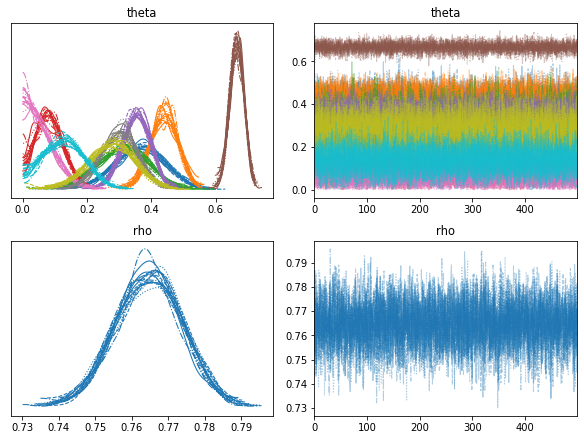

In [10]:
# Evaluate fit with test and trace resample
arviz.plot_trace(resample_fit, figsize=(8, 6));

In [11]:
# View results
#print("Inference on original model:")
#print(fit)
#print('')
print("Inference when trained with test and trace resampling:")
print(resample_fit)
print()
print('Ground truth:')
print(true_transmission_rate)
print(base_rate)
print('Prob(tested | infected): ', p)
print('Prob(tested | not-infected): ', q)

Inference when trained with test and trace resampling':
Inference for Stan model: tt_mod_d348a5d8586623ddc3995113fed4ea2b.
16 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.36  8.3e-4   0.08    0.2   0.31   0.37   0.42   0.51   8852    1.0
theta[2]    0.44  4.6e-4   0.04   0.36   0.41   0.44   0.47   0.52   8298    1.0
theta[3]    0.31  8.8e-4   0.08   0.15   0.26   0.31   0.36   0.46   7910    1.0
theta[4]    0.08  5.3e-4   0.04 8.9e-3   0.05   0.08   0.11   0.17   6339    1.0
theta[5]    0.35  4.7e-4   0.04   0.26   0.32   0.35   0.38   0.44   8720    1.0
theta[6]    0.67  2.5e-4   0.02   0.62   0.65   0.67   0.68   0.71   7729    1.0
theta[7]    0.06  4.9e-4   0.05 2.3e-3   0.02   0.05   0.09   0.17   8377    1.0
theta[8]     0.3  6.3e-4   0.06   0.18   0.26    0.3   0.34   0.41   8237    1.0
theta[9]    0.28  9.5e-4   0.07